In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import numpy as np
from sklearn.metrics import f1_score


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss


class StrokeViT(nn.Module):
    def __init__(self, num_classes=1):
        super(StrokeViT, self).__init__()
        self.resnet = timm.create_model("resnet50", pretrained=True, num_classes=0, global_pool="avg")
        self.vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0, global_pool="")
        self.fc = nn.Linear(2048 + self.vit.embed_dim, num_classes)

    def forward(self, x):
        res_feat = self.resnet(x)
        vit_feat = self.vit.forward_features(x)

        if vit_feat.dim() == 4:       # [B, C, H, W]
            vit_feat = torch.flatten(vit_feat, 1)
        elif vit_feat.dim() == 3:     # [B, N, C]
            vit_feat = vit_feat.mean(dim=1)

        combined = torch.cat((res_feat, vit_feat), dim=1)
        out = self.fc(combined)
        return out


def get_dataloaders(train_dir, val_dir, batch_size=8, img_size=224):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader


def train_model(model, train_loader, val_loader, device, epochs=10, criterion=None,
                save_path="strokevit_best_model_small_resnet.pth", patience=4):

    if criterion is None:
        criterion = FocalLoss(alpha=1, gamma=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        all_train_preds, all_train_labels = [], []
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_train_preds.extend(preds)
            all_train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = (np.array(all_train_preds) == np.array(all_train_labels)).mean() * 100

        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
        val_f1 = f1_score(all_labels, all_preds, average="macro")

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Val Macro F1: {val_f1:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ En iyi model kaydedildi: Epoch {epoch+1}, Val Loss {val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"⚠️ Early stopping counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("⏹️ Eğitim erken durduruldu (early stopping).")
                break

        scheduler.step()

    return model


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dir = "/home/comp5/ARTEK/SYZ_25/ILK_GOREV/VERI/ilk_gorev_veri_split/train"
    val_dir = "/home/comp5/ARTEK/SYZ_25/ILK_GOREV/VERI/ilk_gorev_veri_split/val"
    batch_size = 16
    epochs = 20

    train_loader, val_loader = get_dataloaders(train_dir, val_dir, batch_size=batch_size)
    model = StrokeViT(num_classes=1)
    trained_model = train_model(model, train_loader, val_loader, device, epochs=epochs, patience=4)


/home/comp5/ARTEK/SYZ_25/ikinci_gorev_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Test Accuracy: 78.94%
✅ Test Macro F1: 0.7728


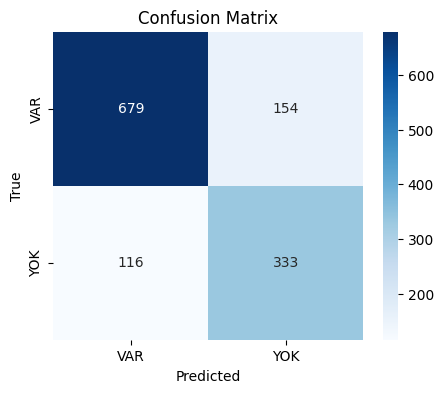

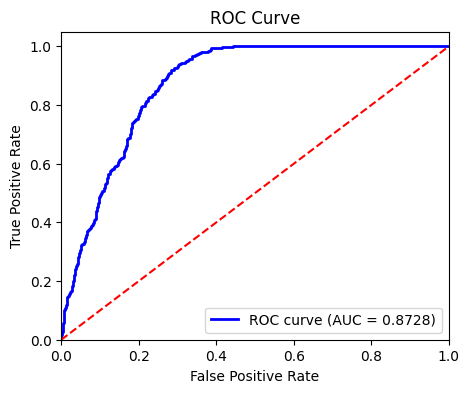

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# StrokeViT Model
# -----------------------------
class StrokeViT(nn.Module):
    def __init__(self, num_classes=1):
        super(StrokeViT, self).__init__()
        self.resnet = timm.create_model("resnet50", pretrained=True, num_classes=0, global_pool="avg")
        self.vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0, global_pool="")
        self.fc = nn.Linear(2048 + self.vit.embed_dim, num_classes)

    def forward(self, x):
        res_feat = self.resnet(x)
        vit_feat = self.vit.forward_features(x)

        if vit_feat.dim() == 4:       # [B, C, H, W]
            vit_feat = torch.flatten(vit_feat, 1)
        elif vit_feat.dim() == 3:     # [B, N, C]
            vit_feat = vit_feat.mean(dim=1)

        combined = torch.cat((res_feat, vit_feat), dim=1)
        out = self.fc(combined)
        return out

# -----------------------------
# Test Fonksiyonu
# -----------------------------
def test_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    acc = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"✅ Test Accuracy: {acc:.2f}%")
    print(f"✅ Test Macro F1: {f1:.4f}")

    # -----------------------------
    # Confusion Matrix
    # -----------------------------
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # -----------------------------
    # ROC Curve & AUC
    # -----------------------------
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return acc, f1, cm, roc_auc

# -----------------------------
# Ana Çalıştırma
# -----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Test veri yolu
    test_dir = "/home/comp5/ARTEK/SYZ_25/SYZ_25_Egitim/genel_veri/2025_Veri/test_veri_seti/ÜNİVERSİTEVEÜZERİ_EGİTİM 2_PNG/BT_TestSet/teknofest_test (11th copy)_preprocessed/test"

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    test_dataset = datasets.ImageFolder(test_dir,
                                         transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

    # Modeli yükle
    model = StrokeViT(num_classes=1)
    model.load_state_dict(torch.load("/home/comp5/ARTEK/SYZ_25/SYZ_25_Egitim/ILK_GOREV/nihai_modeller/resnet50_strokevit_small/strokevit_best_model_small_resnet.pth", map_location=device))
    model.to(device)

    # Test et
    class_names = test_dataset.classes  # ["no_stroke", "stroke"] gibi
    test_model(model, test_loader, device, class_names=class_names)
